# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

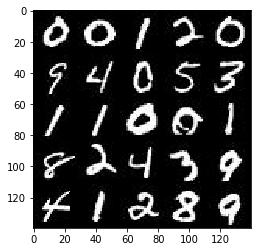

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

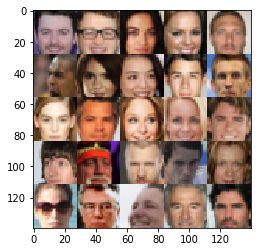

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)
        # 8x8x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # shape = 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # shape = 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)   
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        # shape = 28x28x3
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    _, width, height, channel = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *=2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # print the losses every 100 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..., step {}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, channel, data_image_mode)

        saver.save(sess, './generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2..., step 10 Discriminator Loss: 0.0001... Generator Loss: 11.3873
Epoch 1/2..., step 20 Discriminator Loss: 0.0006... Generator Loss: 7.6045
Epoch 1/2..., step 30 Discriminator Loss: 3.4917... Generator Loss: 16.4946
Epoch 1/2..., step 40 Discriminator Loss: 0.0784... Generator Loss: 4.6847
Epoch 1/2..., step 50 Discriminator Loss: 0.6382... Generator Loss: 5.1721
Epoch 1/2..., step 60 Discriminator Loss: 0.2422... Generator Loss: 2.3984
Epoch 1/2..., step 70 Discriminator Loss: 1.8347... Generator Loss: 0.3362
Epoch 1/2..., step 80 Discriminator Loss: 1.4340... Generator Loss: 1.2864
Epoch 1/2..., step 90 Discriminator Loss: 0.9865... Generator Loss: 0.6878
Epoch 1/2..., step 100 Discriminator Loss: 1.1711... Generator Loss: 0.9732


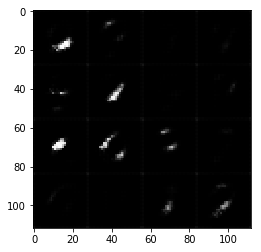

Epoch 1/2..., step 110 Discriminator Loss: 1.0695... Generator Loss: 0.8264
Epoch 1/2..., step 120 Discriminator Loss: 0.9342... Generator Loss: 1.4905
Epoch 1/2..., step 130 Discriminator Loss: 1.5249... Generator Loss: 0.3840
Epoch 1/2..., step 140 Discriminator Loss: 2.3023... Generator Loss: 0.1625
Epoch 1/2..., step 150 Discriminator Loss: 0.8277... Generator Loss: 0.9077
Epoch 1/2..., step 160 Discriminator Loss: 0.8552... Generator Loss: 2.3255
Epoch 1/2..., step 170 Discriminator Loss: 1.0100... Generator Loss: 0.7701
Epoch 1/2..., step 180 Discriminator Loss: 1.3455... Generator Loss: 0.4500
Epoch 1/2..., step 190 Discriminator Loss: 1.3339... Generator Loss: 1.9703
Epoch 1/2..., step 200 Discriminator Loss: 0.9430... Generator Loss: 1.0576


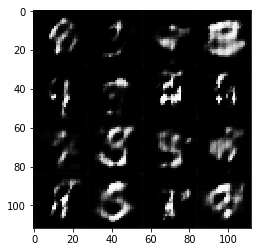

Epoch 1/2..., step 210 Discriminator Loss: 1.3542... Generator Loss: 1.4777
Epoch 1/2..., step 220 Discriminator Loss: 0.9388... Generator Loss: 1.1539
Epoch 1/2..., step 230 Discriminator Loss: 1.1947... Generator Loss: 2.4215
Epoch 1/2..., step 240 Discriminator Loss: 1.2414... Generator Loss: 1.9931
Epoch 1/2..., step 250 Discriminator Loss: 1.2576... Generator Loss: 0.5044
Epoch 1/2..., step 260 Discriminator Loss: 0.9983... Generator Loss: 0.8865
Epoch 1/2..., step 270 Discriminator Loss: 1.2260... Generator Loss: 0.8142
Epoch 1/2..., step 280 Discriminator Loss: 1.4493... Generator Loss: 0.4655
Epoch 1/2..., step 290 Discriminator Loss: 1.2180... Generator Loss: 0.5711
Epoch 1/2..., step 300 Discriminator Loss: 1.1205... Generator Loss: 0.7836


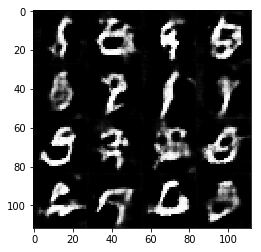

Epoch 1/2..., step 310 Discriminator Loss: 1.6244... Generator Loss: 0.3180
Epoch 1/2..., step 320 Discriminator Loss: 1.1132... Generator Loss: 0.9777
Epoch 1/2..., step 330 Discriminator Loss: 1.1640... Generator Loss: 0.5688
Epoch 1/2..., step 340 Discriminator Loss: 1.3579... Generator Loss: 1.2034
Epoch 1/2..., step 350 Discriminator Loss: 1.0208... Generator Loss: 1.3977
Epoch 1/2..., step 360 Discriminator Loss: 1.2221... Generator Loss: 0.5653
Epoch 1/2..., step 370 Discriminator Loss: 1.1234... Generator Loss: 1.0161
Epoch 1/2..., step 380 Discriminator Loss: 1.2476... Generator Loss: 0.5433
Epoch 1/2..., step 390 Discriminator Loss: 0.9097... Generator Loss: 1.1381
Epoch 1/2..., step 400 Discriminator Loss: 1.2981... Generator Loss: 2.2534


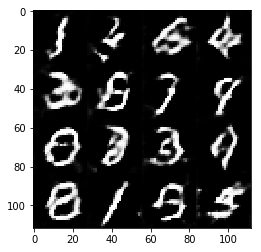

Epoch 1/2..., step 410 Discriminator Loss: 1.5471... Generator Loss: 0.3523
Epoch 1/2..., step 420 Discriminator Loss: 1.0333... Generator Loss: 0.9364
Epoch 1/2..., step 430 Discriminator Loss: 1.1951... Generator Loss: 0.9455
Epoch 1/2..., step 440 Discriminator Loss: 1.1680... Generator Loss: 1.5938
Epoch 1/2..., step 450 Discriminator Loss: 1.1373... Generator Loss: 0.9696
Epoch 1/2..., step 460 Discriminator Loss: 1.2112... Generator Loss: 0.6181
Epoch 1/2..., step 470 Discriminator Loss: 1.2232... Generator Loss: 1.0238
Epoch 1/2..., step 480 Discriminator Loss: 1.7762... Generator Loss: 0.2595
Epoch 1/2..., step 490 Discriminator Loss: 1.0701... Generator Loss: 0.6412
Epoch 1/2..., step 500 Discriminator Loss: 1.6579... Generator Loss: 0.3646


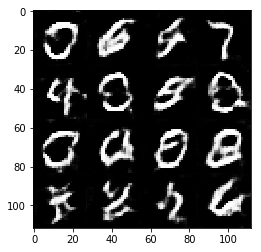

Epoch 1/2..., step 510 Discriminator Loss: 1.1652... Generator Loss: 0.6780
Epoch 1/2..., step 520 Discriminator Loss: 1.2173... Generator Loss: 0.9693
Epoch 1/2..., step 530 Discriminator Loss: 0.9701... Generator Loss: 0.8400
Epoch 1/2..., step 540 Discriminator Loss: 1.1820... Generator Loss: 0.6761
Epoch 1/2..., step 550 Discriminator Loss: 0.9046... Generator Loss: 1.2136
Epoch 1/2..., step 560 Discriminator Loss: 0.9308... Generator Loss: 1.0526
Epoch 1/2..., step 570 Discriminator Loss: 1.0052... Generator Loss: 0.9528
Epoch 1/2..., step 580 Discriminator Loss: 1.0729... Generator Loss: 1.6516
Epoch 1/2..., step 590 Discriminator Loss: 1.7718... Generator Loss: 0.2538
Epoch 1/2..., step 600 Discriminator Loss: 0.9918... Generator Loss: 0.7906


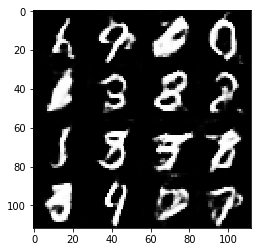

Epoch 1/2..., step 610 Discriminator Loss: 1.0132... Generator Loss: 1.3166
Epoch 1/2..., step 620 Discriminator Loss: 0.9467... Generator Loss: 1.0191
Epoch 1/2..., step 630 Discriminator Loss: 0.9686... Generator Loss: 0.9604
Epoch 1/2..., step 640 Discriminator Loss: 1.0204... Generator Loss: 0.9310
Epoch 1/2..., step 650 Discriminator Loss: 1.0485... Generator Loss: 0.8824
Epoch 1/2..., step 660 Discriminator Loss: 1.3188... Generator Loss: 1.7983
Epoch 1/2..., step 670 Discriminator Loss: 1.1910... Generator Loss: 0.5468
Epoch 1/2..., step 680 Discriminator Loss: 1.1005... Generator Loss: 0.9728
Epoch 1/2..., step 690 Discriminator Loss: 1.0393... Generator Loss: 1.3336
Epoch 1/2..., step 700 Discriminator Loss: 1.0269... Generator Loss: 1.5738


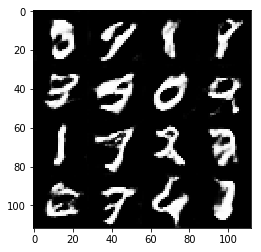

Epoch 1/2..., step 710 Discriminator Loss: 1.5408... Generator Loss: 0.3628
Epoch 1/2..., step 720 Discriminator Loss: 1.1151... Generator Loss: 1.4586
Epoch 1/2..., step 730 Discriminator Loss: 1.1939... Generator Loss: 0.6172
Epoch 1/2..., step 740 Discriminator Loss: 1.2128... Generator Loss: 0.5657
Epoch 1/2..., step 750 Discriminator Loss: 1.1079... Generator Loss: 1.1361
Epoch 1/2..., step 760 Discriminator Loss: 1.0738... Generator Loss: 0.6271
Epoch 1/2..., step 770 Discriminator Loss: 0.8991... Generator Loss: 1.1622
Epoch 1/2..., step 780 Discriminator Loss: 1.0809... Generator Loss: 0.7272
Epoch 1/2..., step 790 Discriminator Loss: 0.9987... Generator Loss: 1.2890
Epoch 1/2..., step 800 Discriminator Loss: 1.2778... Generator Loss: 0.5109


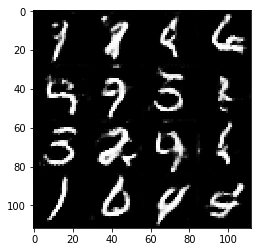

Epoch 1/2..., step 810 Discriminator Loss: 1.0227... Generator Loss: 0.7711
Epoch 1/2..., step 820 Discriminator Loss: 1.1340... Generator Loss: 0.6622
Epoch 1/2..., step 830 Discriminator Loss: 1.1986... Generator Loss: 0.5996
Epoch 1/2..., step 840 Discriminator Loss: 1.0203... Generator Loss: 1.2700
Epoch 1/2..., step 850 Discriminator Loss: 1.0427... Generator Loss: 1.0899
Epoch 1/2..., step 860 Discriminator Loss: 1.5003... Generator Loss: 0.4028
Epoch 1/2..., step 870 Discriminator Loss: 1.0211... Generator Loss: 1.0896
Epoch 1/2..., step 880 Discriminator Loss: 1.6244... Generator Loss: 1.8767
Epoch 1/2..., step 890 Discriminator Loss: 0.9750... Generator Loss: 1.0584
Epoch 1/2..., step 900 Discriminator Loss: 1.2697... Generator Loss: 0.5610


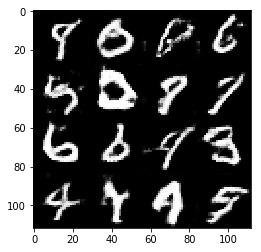

Epoch 1/2..., step 910 Discriminator Loss: 1.2031... Generator Loss: 0.5582
Epoch 1/2..., step 920 Discriminator Loss: 1.0304... Generator Loss: 0.6411
Epoch 1/2..., step 930 Discriminator Loss: 0.9050... Generator Loss: 1.0728
Epoch 2/2..., step 940 Discriminator Loss: 1.3475... Generator Loss: 0.4169
Epoch 2/2..., step 950 Discriminator Loss: 1.0741... Generator Loss: 1.1796
Epoch 2/2..., step 960 Discriminator Loss: 0.7627... Generator Loss: 1.2415
Epoch 2/2..., step 970 Discriminator Loss: 1.1021... Generator Loss: 0.5392
Epoch 2/2..., step 980 Discriminator Loss: 1.2517... Generator Loss: 0.7256
Epoch 2/2..., step 990 Discriminator Loss: 1.0560... Generator Loss: 0.8163
Epoch 2/2..., step 1000 Discriminator Loss: 0.9892... Generator Loss: 0.7737


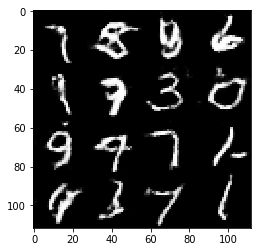

Epoch 2/2..., step 1010 Discriminator Loss: 1.0552... Generator Loss: 0.9952
Epoch 2/2..., step 1020 Discriminator Loss: 1.1113... Generator Loss: 0.6442
Epoch 2/2..., step 1030 Discriminator Loss: 0.9654... Generator Loss: 1.2939
Epoch 2/2..., step 1040 Discriminator Loss: 1.5315... Generator Loss: 0.3634
Epoch 2/2..., step 1050 Discriminator Loss: 1.1742... Generator Loss: 0.5299
Epoch 2/2..., step 1060 Discriminator Loss: 1.3300... Generator Loss: 0.4801
Epoch 2/2..., step 1070 Discriminator Loss: 1.3758... Generator Loss: 2.3261
Epoch 2/2..., step 1080 Discriminator Loss: 0.9831... Generator Loss: 0.7738
Epoch 2/2..., step 1090 Discriminator Loss: 0.7710... Generator Loss: 1.6969
Epoch 2/2..., step 1100 Discriminator Loss: 1.4876... Generator Loss: 0.3787


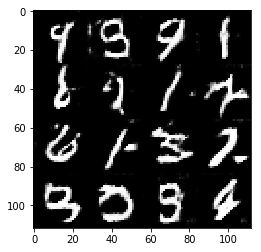

Epoch 2/2..., step 1110 Discriminator Loss: 1.0205... Generator Loss: 1.1475
Epoch 2/2..., step 1120 Discriminator Loss: 0.9152... Generator Loss: 0.9096
Epoch 2/2..., step 1130 Discriminator Loss: 1.1703... Generator Loss: 0.7543
Epoch 2/2..., step 1140 Discriminator Loss: 1.0256... Generator Loss: 0.7462
Epoch 2/2..., step 1150 Discriminator Loss: 1.0661... Generator Loss: 0.7527
Epoch 2/2..., step 1160 Discriminator Loss: 0.8595... Generator Loss: 0.8660
Epoch 2/2..., step 1170 Discriminator Loss: 1.0400... Generator Loss: 1.1731
Epoch 2/2..., step 1180 Discriminator Loss: 1.2876... Generator Loss: 1.6941
Epoch 2/2..., step 1190 Discriminator Loss: 1.0493... Generator Loss: 1.2576
Epoch 2/2..., step 1200 Discriminator Loss: 1.0564... Generator Loss: 1.2431


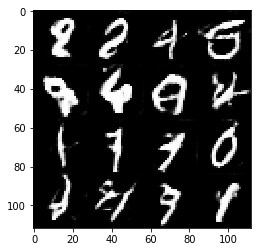

Epoch 2/2..., step 1210 Discriminator Loss: 0.9602... Generator Loss: 0.9628
Epoch 2/2..., step 1220 Discriminator Loss: 0.8618... Generator Loss: 1.2959
Epoch 2/2..., step 1230 Discriminator Loss: 0.5945... Generator Loss: 1.7977
Epoch 2/2..., step 1240 Discriminator Loss: 0.9374... Generator Loss: 0.7321
Epoch 2/2..., step 1250 Discriminator Loss: 1.2428... Generator Loss: 1.7546
Epoch 2/2..., step 1260 Discriminator Loss: 1.1502... Generator Loss: 1.1108
Epoch 2/2..., step 1270 Discriminator Loss: 1.0386... Generator Loss: 1.4909
Epoch 2/2..., step 1280 Discriminator Loss: 0.8809... Generator Loss: 0.9680
Epoch 2/2..., step 1290 Discriminator Loss: 0.8323... Generator Loss: 1.2032
Epoch 2/2..., step 1300 Discriminator Loss: 0.9070... Generator Loss: 1.7973


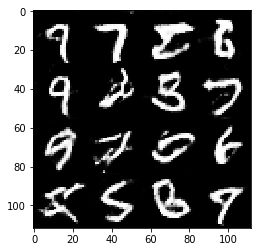

Epoch 2/2..., step 1310 Discriminator Loss: 1.4894... Generator Loss: 0.4076
Epoch 2/2..., step 1320 Discriminator Loss: 0.8146... Generator Loss: 1.0364
Epoch 2/2..., step 1330 Discriminator Loss: 1.1088... Generator Loss: 0.5916
Epoch 2/2..., step 1340 Discriminator Loss: 1.1675... Generator Loss: 0.5457
Epoch 2/2..., step 1350 Discriminator Loss: 1.0153... Generator Loss: 1.8576
Epoch 2/2..., step 1360 Discriminator Loss: 0.8846... Generator Loss: 1.1068
Epoch 2/2..., step 1370 Discriminator Loss: 0.8963... Generator Loss: 1.1353
Epoch 2/2..., step 1380 Discriminator Loss: 1.0256... Generator Loss: 0.6976
Epoch 2/2..., step 1390 Discriminator Loss: 0.9691... Generator Loss: 1.1761
Epoch 2/2..., step 1400 Discriminator Loss: 1.5818... Generator Loss: 0.3760


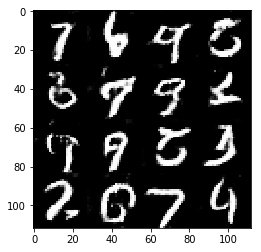

Epoch 2/2..., step 1410 Discriminator Loss: 1.0702... Generator Loss: 0.8526
Epoch 2/2..., step 1420 Discriminator Loss: 1.4115... Generator Loss: 0.4351
Epoch 2/2..., step 1430 Discriminator Loss: 1.1259... Generator Loss: 0.6607
Epoch 2/2..., step 1440 Discriminator Loss: 1.0433... Generator Loss: 1.0497
Epoch 2/2..., step 1450 Discriminator Loss: 1.0306... Generator Loss: 1.4045
Epoch 2/2..., step 1460 Discriminator Loss: 1.0094... Generator Loss: 1.0025
Epoch 2/2..., step 1470 Discriminator Loss: 1.4701... Generator Loss: 0.3639
Epoch 2/2..., step 1480 Discriminator Loss: 0.9117... Generator Loss: 0.8769
Epoch 2/2..., step 1490 Discriminator Loss: 1.5321... Generator Loss: 0.4162
Epoch 2/2..., step 1500 Discriminator Loss: 0.9339... Generator Loss: 1.2894


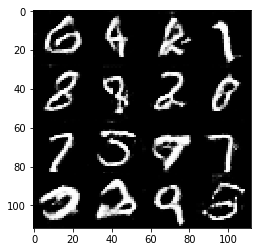

Epoch 2/2..., step 1510 Discriminator Loss: 0.8576... Generator Loss: 0.8516
Epoch 2/2..., step 1520 Discriminator Loss: 1.2054... Generator Loss: 0.5783
Epoch 2/2..., step 1530 Discriminator Loss: 1.5333... Generator Loss: 0.3458
Epoch 2/2..., step 1540 Discriminator Loss: 1.3823... Generator Loss: 1.8089
Epoch 2/2..., step 1550 Discriminator Loss: 1.0665... Generator Loss: 0.9247
Epoch 2/2..., step 1560 Discriminator Loss: 0.9590... Generator Loss: 0.8759
Epoch 2/2..., step 1570 Discriminator Loss: 1.4868... Generator Loss: 0.3675
Epoch 2/2..., step 1580 Discriminator Loss: 1.4090... Generator Loss: 0.4087
Epoch 2/2..., step 1590 Discriminator Loss: 1.0081... Generator Loss: 0.6837
Epoch 2/2..., step 1600 Discriminator Loss: 1.2102... Generator Loss: 0.5772


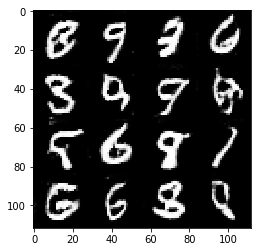

Epoch 2/2..., step 1610 Discriminator Loss: 1.3908... Generator Loss: 0.4548
Epoch 2/2..., step 1620 Discriminator Loss: 1.0358... Generator Loss: 1.3925
Epoch 2/2..., step 1630 Discriminator Loss: 0.7879... Generator Loss: 1.0280
Epoch 2/2..., step 1640 Discriminator Loss: 0.9767... Generator Loss: 0.8115
Epoch 2/2..., step 1650 Discriminator Loss: 0.9215... Generator Loss: 0.8267
Epoch 2/2..., step 1660 Discriminator Loss: 1.0075... Generator Loss: 2.0719
Epoch 2/2..., step 1670 Discriminator Loss: 1.2840... Generator Loss: 0.5867
Epoch 2/2..., step 1680 Discriminator Loss: 1.0272... Generator Loss: 1.2820
Epoch 2/2..., step 1690 Discriminator Loss: 1.0731... Generator Loss: 0.6450
Epoch 2/2..., step 1700 Discriminator Loss: 0.7729... Generator Loss: 0.8310


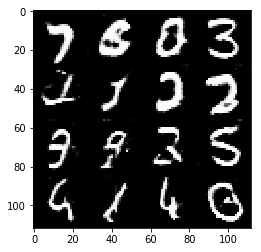

Epoch 2/2..., step 1710 Discriminator Loss: 1.1897... Generator Loss: 0.5774
Epoch 2/2..., step 1720 Discriminator Loss: 0.6846... Generator Loss: 1.4111
Epoch 2/2..., step 1730 Discriminator Loss: 0.8283... Generator Loss: 1.9178
Epoch 2/2..., step 1740 Discriminator Loss: 1.7875... Generator Loss: 0.2671
Epoch 2/2..., step 1750 Discriminator Loss: 0.6742... Generator Loss: 1.3832
Epoch 2/2..., step 1760 Discriminator Loss: 1.5921... Generator Loss: 2.2962
Epoch 2/2..., step 1770 Discriminator Loss: 1.0113... Generator Loss: 1.0106
Epoch 2/2..., step 1780 Discriminator Loss: 1.1344... Generator Loss: 0.7178
Epoch 2/2..., step 1790 Discriminator Loss: 1.0687... Generator Loss: 0.5906
Epoch 2/2..., step 1800 Discriminator Loss: 0.8297... Generator Loss: 0.8359


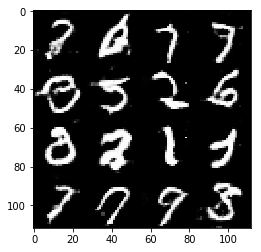

Epoch 2/2..., step 1810 Discriminator Loss: 1.3274... Generator Loss: 1.4796
Epoch 2/2..., step 1820 Discriminator Loss: 1.1376... Generator Loss: 1.0207
Epoch 2/2..., step 1830 Discriminator Loss: 0.9348... Generator Loss: 0.9393
Epoch 2/2..., step 1840 Discriminator Loss: 1.0206... Generator Loss: 0.9256
Epoch 2/2..., step 1850 Discriminator Loss: 1.2481... Generator Loss: 0.5294
Epoch 2/2..., step 1860 Discriminator Loss: 1.4395... Generator Loss: 0.4169
Epoch 2/2..., step 1870 Discriminator Loss: 0.8508... Generator Loss: 1.4361


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1..., step 10 Discriminator Loss: 0.4641... Generator Loss: 1.8975
Epoch 1/1..., step 20 Discriminator Loss: 0.5490... Generator Loss: 1.8773
Epoch 1/1..., step 30 Discriminator Loss: 0.3197... Generator Loss: 2.4293
Epoch 1/1..., step 40 Discriminator Loss: 1.8150... Generator Loss: 6.4880
Epoch 1/1..., step 50 Discriminator Loss: 0.9241... Generator Loss: 3.0409
Epoch 1/1..., step 60 Discriminator Loss: 1.0858... Generator Loss: 1.7704
Epoch 1/1..., step 70 Discriminator Loss: 1.3848... Generator Loss: 0.3996
Epoch 1/1..., step 80 Discriminator Loss: 0.4199... Generator Loss: 4.4498
Epoch 1/1..., step 90 Discriminator Loss: 1.2800... Generator Loss: 0.5087
Epoch 1/1..., step 100 Discriminator Loss: 1.0551... Generator Loss: 0.8539


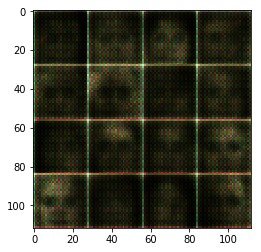

Epoch 1/1..., step 110 Discriminator Loss: 0.6007... Generator Loss: 4.2458
Epoch 1/1..., step 120 Discriminator Loss: 0.6314... Generator Loss: 1.1422
Epoch 1/1..., step 130 Discriminator Loss: 0.4276... Generator Loss: 1.9330
Epoch 1/1..., step 140 Discriminator Loss: 0.4352... Generator Loss: 2.6424
Epoch 1/1..., step 150 Discriminator Loss: 0.6126... Generator Loss: 1.3950
Epoch 1/1..., step 160 Discriminator Loss: 0.5591... Generator Loss: 3.2260
Epoch 1/1..., step 170 Discriminator Loss: 0.6728... Generator Loss: 2.9862
Epoch 1/1..., step 180 Discriminator Loss: 1.4627... Generator Loss: 0.4585
Epoch 1/1..., step 190 Discriminator Loss: 1.1693... Generator Loss: 3.1314
Epoch 1/1..., step 200 Discriminator Loss: 0.6939... Generator Loss: 1.0932


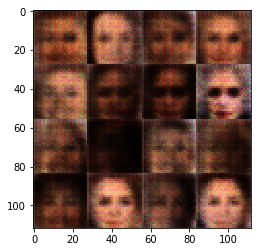

Epoch 1/1..., step 210 Discriminator Loss: 0.7920... Generator Loss: 1.2903
Epoch 1/1..., step 220 Discriminator Loss: 1.2313... Generator Loss: 0.4920
Epoch 1/1..., step 230 Discriminator Loss: 1.4750... Generator Loss: 0.4259
Epoch 1/1..., step 240 Discriminator Loss: 1.0830... Generator Loss: 1.1226
Epoch 1/1..., step 250 Discriminator Loss: 0.9659... Generator Loss: 1.3577
Epoch 1/1..., step 260 Discriminator Loss: 0.6035... Generator Loss: 1.8612
Epoch 1/1..., step 270 Discriminator Loss: 0.6443... Generator Loss: 2.7082
Epoch 1/1..., step 280 Discriminator Loss: 1.0969... Generator Loss: 2.1118
Epoch 1/1..., step 290 Discriminator Loss: 0.8979... Generator Loss: 1.0637
Epoch 1/1..., step 300 Discriminator Loss: 0.3955... Generator Loss: 1.9064


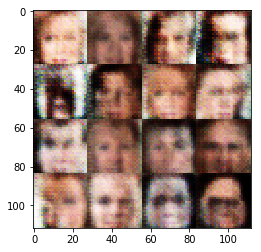

Epoch 1/1..., step 310 Discriminator Loss: 1.4083... Generator Loss: 0.4287
Epoch 1/1..., step 320 Discriminator Loss: 1.1626... Generator Loss: 1.8076
Epoch 1/1..., step 330 Discriminator Loss: 1.3192... Generator Loss: 2.1223
Epoch 1/1..., step 340 Discriminator Loss: 0.7160... Generator Loss: 2.6813
Epoch 1/1..., step 350 Discriminator Loss: 0.4827... Generator Loss: 2.6554
Epoch 1/1..., step 360 Discriminator Loss: 1.0964... Generator Loss: 0.5494
Epoch 1/1..., step 370 Discriminator Loss: 2.0426... Generator Loss: 3.3031
Epoch 1/1..., step 380 Discriminator Loss: 1.0669... Generator Loss: 1.0986
Epoch 1/1..., step 390 Discriminator Loss: 0.8817... Generator Loss: 1.0836
Epoch 1/1..., step 400 Discriminator Loss: 1.0145... Generator Loss: 0.6678


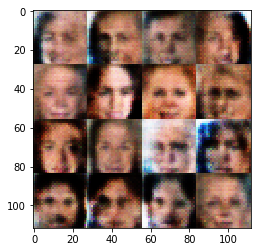

Epoch 1/1..., step 410 Discriminator Loss: 0.8669... Generator Loss: 1.6921
Epoch 1/1..., step 420 Discriminator Loss: 0.8674... Generator Loss: 0.8166
Epoch 1/1..., step 430 Discriminator Loss: 1.3005... Generator Loss: 0.3988
Epoch 1/1..., step 440 Discriminator Loss: 0.3736... Generator Loss: 1.9409
Epoch 1/1..., step 450 Discriminator Loss: 1.5750... Generator Loss: 1.8044
Epoch 1/1..., step 460 Discriminator Loss: 0.4631... Generator Loss: 2.8185
Epoch 1/1..., step 470 Discriminator Loss: 0.6423... Generator Loss: 2.0558
Epoch 1/1..., step 480 Discriminator Loss: 0.6249... Generator Loss: 2.2192
Epoch 1/1..., step 490 Discriminator Loss: 1.8194... Generator Loss: 0.4563
Epoch 1/1..., step 500 Discriminator Loss: 0.8648... Generator Loss: 1.0561


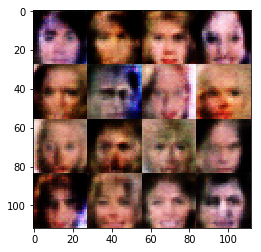

Epoch 1/1..., step 510 Discriminator Loss: 1.5120... Generator Loss: 0.3502
Epoch 1/1..., step 520 Discriminator Loss: 1.4940... Generator Loss: 0.6861
Epoch 1/1..., step 530 Discriminator Loss: 0.9001... Generator Loss: 0.9658
Epoch 1/1..., step 540 Discriminator Loss: 0.5689... Generator Loss: 1.9395
Epoch 1/1..., step 550 Discriminator Loss: 1.1815... Generator Loss: 0.8358
Epoch 1/1..., step 560 Discriminator Loss: 0.9838... Generator Loss: 0.7904
Epoch 1/1..., step 570 Discriminator Loss: 0.8487... Generator Loss: 0.7700
Epoch 1/1..., step 580 Discriminator Loss: 0.2788... Generator Loss: 3.4141
Epoch 1/1..., step 590 Discriminator Loss: 1.6796... Generator Loss: 0.2721
Epoch 1/1..., step 600 Discriminator Loss: 0.5984... Generator Loss: 1.3606


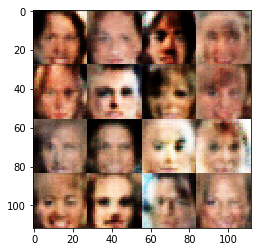

Epoch 1/1..., step 610 Discriminator Loss: 0.7993... Generator Loss: 2.5517
Epoch 1/1..., step 620 Discriminator Loss: 1.1426... Generator Loss: 0.5918
Epoch 1/1..., step 630 Discriminator Loss: 1.1989... Generator Loss: 0.6140
Epoch 1/1..., step 640 Discriminator Loss: 1.3731... Generator Loss: 0.4994
Epoch 1/1..., step 650 Discriminator Loss: 0.9187... Generator Loss: 1.0874
Epoch 1/1..., step 660 Discriminator Loss: 1.5613... Generator Loss: 0.3223
Epoch 1/1..., step 670 Discriminator Loss: 1.6867... Generator Loss: 1.5782
Epoch 1/1..., step 680 Discriminator Loss: 1.3605... Generator Loss: 0.4308
Epoch 1/1..., step 690 Discriminator Loss: 0.6215... Generator Loss: 1.8654
Epoch 1/1..., step 700 Discriminator Loss: 0.5974... Generator Loss: 1.9423


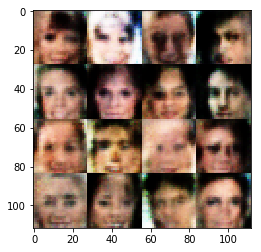

Epoch 1/1..., step 710 Discriminator Loss: 2.7114... Generator Loss: 2.5747
Epoch 1/1..., step 720 Discriminator Loss: 0.7819... Generator Loss: 2.3682
Epoch 1/1..., step 730 Discriminator Loss: 0.8157... Generator Loss: 0.8489
Epoch 1/1..., step 740 Discriminator Loss: 0.6913... Generator Loss: 1.3790
Epoch 1/1..., step 750 Discriminator Loss: 1.2618... Generator Loss: 1.1670
Epoch 1/1..., step 760 Discriminator Loss: 0.4616... Generator Loss: 1.5467
Epoch 1/1..., step 770 Discriminator Loss: 0.5365... Generator Loss: 2.1127
Epoch 1/1..., step 780 Discriminator Loss: 0.4143... Generator Loss: 1.8643
Epoch 1/1..., step 790 Discriminator Loss: 1.0195... Generator Loss: 0.6226
Epoch 1/1..., step 800 Discriminator Loss: 0.3584... Generator Loss: 3.5852


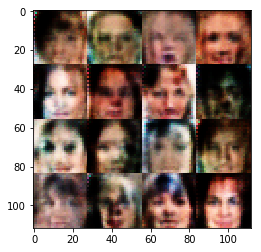

Epoch 1/1..., step 810 Discriminator Loss: 2.7306... Generator Loss: 1.9231
Epoch 1/1..., step 820 Discriminator Loss: 0.4611... Generator Loss: 2.3167
Epoch 1/1..., step 830 Discriminator Loss: 0.5163... Generator Loss: 1.4056
Epoch 1/1..., step 840 Discriminator Loss: 1.0739... Generator Loss: 0.5591
Epoch 1/1..., step 850 Discriminator Loss: 0.5311... Generator Loss: 2.2203
Epoch 1/1..., step 860 Discriminator Loss: 0.6251... Generator Loss: 1.1408
Epoch 1/1..., step 870 Discriminator Loss: 0.7744... Generator Loss: 0.8047
Epoch 1/1..., step 880 Discriminator Loss: 0.8504... Generator Loss: 0.8067
Epoch 1/1..., step 890 Discriminator Loss: 1.4007... Generator Loss: 0.4148
Epoch 1/1..., step 900 Discriminator Loss: 1.0560... Generator Loss: 0.5840


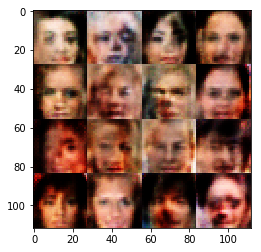

Epoch 1/1..., step 910 Discriminator Loss: 0.5363... Generator Loss: 2.0563
Epoch 1/1..., step 920 Discriminator Loss: 0.9940... Generator Loss: 0.6111
Epoch 1/1..., step 930 Discriminator Loss: 1.5340... Generator Loss: 0.9152
Epoch 1/1..., step 940 Discriminator Loss: 0.9686... Generator Loss: 0.6677
Epoch 1/1..., step 950 Discriminator Loss: 0.5179... Generator Loss: 1.6789
Epoch 1/1..., step 960 Discriminator Loss: 0.6447... Generator Loss: 1.6342
Epoch 1/1..., step 970 Discriminator Loss: 0.7496... Generator Loss: 1.3829
Epoch 1/1..., step 980 Discriminator Loss: 0.8674... Generator Loss: 1.7236
Epoch 1/1..., step 990 Discriminator Loss: 0.4738... Generator Loss: 3.2002
Epoch 1/1..., step 1000 Discriminator Loss: 0.6894... Generator Loss: 1.1839


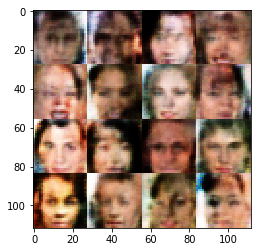

Epoch 1/1..., step 1010 Discriminator Loss: 0.4711... Generator Loss: 3.2888
Epoch 1/1..., step 1020 Discriminator Loss: 0.4310... Generator Loss: 2.0700
Epoch 1/1..., step 1030 Discriminator Loss: 2.4933... Generator Loss: 0.9688
Epoch 1/1..., step 1040 Discriminator Loss: 0.3356... Generator Loss: 2.4106
Epoch 1/1..., step 1050 Discriminator Loss: 0.5205... Generator Loss: 1.3637
Epoch 1/1..., step 1060 Discriminator Loss: 0.2298... Generator Loss: 5.0326
Epoch 1/1..., step 1070 Discriminator Loss: 0.8392... Generator Loss: 0.6771
Epoch 1/1..., step 1080 Discriminator Loss: 0.4451... Generator Loss: 1.7604
Epoch 1/1..., step 1090 Discriminator Loss: 2.6480... Generator Loss: 0.0881
Epoch 1/1..., step 1100 Discriminator Loss: 0.7150... Generator Loss: 0.9137


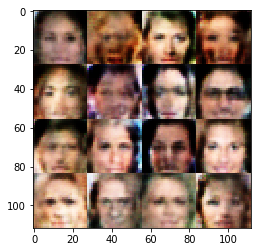

Epoch 1/1..., step 1110 Discriminator Loss: 2.6562... Generator Loss: 0.1049
Epoch 1/1..., step 1120 Discriminator Loss: 0.3539... Generator Loss: 2.2588
Epoch 1/1..., step 1130 Discriminator Loss: 1.4213... Generator Loss: 0.3586
Epoch 1/1..., step 1140 Discriminator Loss: 0.3429... Generator Loss: 2.9545
Epoch 1/1..., step 1150 Discriminator Loss: 0.3215... Generator Loss: 2.0169
Epoch 1/1..., step 1160 Discriminator Loss: 0.7106... Generator Loss: 0.9121
Epoch 1/1..., step 1170 Discriminator Loss: 0.3195... Generator Loss: 3.4384
Epoch 1/1..., step 1180 Discriminator Loss: 0.5949... Generator Loss: 1.2163
Epoch 1/1..., step 1190 Discriminator Loss: 0.6857... Generator Loss: 2.4781
Epoch 1/1..., step 1200 Discriminator Loss: 0.3086... Generator Loss: 2.8731


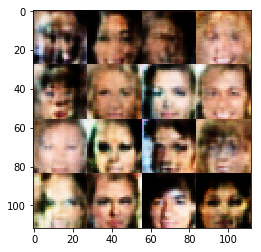

Epoch 1/1..., step 1210 Discriminator Loss: 0.2296... Generator Loss: 2.0505
Epoch 1/1..., step 1220 Discriminator Loss: 2.5141... Generator Loss: 0.1153
Epoch 1/1..., step 1230 Discriminator Loss: 1.1847... Generator Loss: 0.5893
Epoch 1/1..., step 1240 Discriminator Loss: 0.5510... Generator Loss: 1.4798
Epoch 1/1..., step 1250 Discriminator Loss: 0.3038... Generator Loss: 2.3657
Epoch 1/1..., step 1260 Discriminator Loss: 2.8048... Generator Loss: 0.0927
Epoch 1/1..., step 1270 Discriminator Loss: 0.9400... Generator Loss: 0.6394
Epoch 1/1..., step 1280 Discriminator Loss: 0.5127... Generator Loss: 1.4077
Epoch 1/1..., step 1290 Discriminator Loss: 0.3813... Generator Loss: 1.9015
Epoch 1/1..., step 1300 Discriminator Loss: 0.2317... Generator Loss: 3.1649


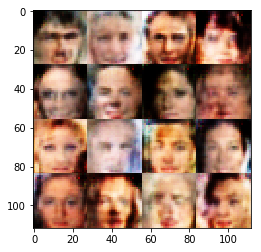

Epoch 1/1..., step 1310 Discriminator Loss: 0.2984... Generator Loss: 2.6613
Epoch 1/1..., step 1320 Discriminator Loss: 0.7916... Generator Loss: 0.7417
Epoch 1/1..., step 1330 Discriminator Loss: 0.3788... Generator Loss: 1.8358
Epoch 1/1..., step 1340 Discriminator Loss: 0.1734... Generator Loss: 3.3285
Epoch 1/1..., step 1350 Discriminator Loss: 0.3722... Generator Loss: 1.8366
Epoch 1/1..., step 1360 Discriminator Loss: 0.1236... Generator Loss: 2.9682
Epoch 1/1..., step 1370 Discriminator Loss: 0.6142... Generator Loss: 1.1791
Epoch 1/1..., step 1380 Discriminator Loss: 0.3971... Generator Loss: 1.6390
Epoch 1/1..., step 1390 Discriminator Loss: 0.3895... Generator Loss: 1.9607
Epoch 1/1..., step 1400 Discriminator Loss: 2.4856... Generator Loss: 2.0703


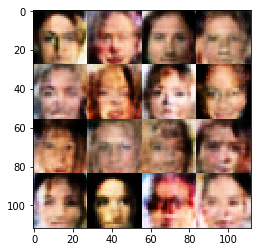

Epoch 1/1..., step 1410 Discriminator Loss: 0.4401... Generator Loss: 2.2627
Epoch 1/1..., step 1420 Discriminator Loss: 0.5475... Generator Loss: 1.2498
Epoch 1/1..., step 1430 Discriminator Loss: 0.4019... Generator Loss: 1.9051
Epoch 1/1..., step 1440 Discriminator Loss: 0.4885... Generator Loss: 3.2986
Epoch 1/1..., step 1450 Discriminator Loss: 0.5643... Generator Loss: 1.1044
Epoch 1/1..., step 1460 Discriminator Loss: 0.4190... Generator Loss: 1.5373
Epoch 1/1..., step 1470 Discriminator Loss: 0.2958... Generator Loss: 2.1267
Epoch 1/1..., step 1480 Discriminator Loss: 0.3167... Generator Loss: 2.1176
Epoch 1/1..., step 1490 Discriminator Loss: 0.2215... Generator Loss: 3.3121
Epoch 1/1..., step 1500 Discriminator Loss: 2.1171... Generator Loss: 0.1560


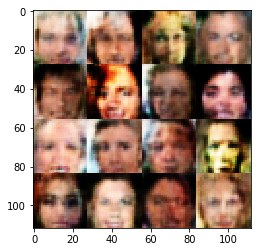

Epoch 1/1..., step 1510 Discriminator Loss: 0.2854... Generator Loss: 2.4541
Epoch 1/1..., step 1520 Discriminator Loss: 1.1634... Generator Loss: 1.2659
Epoch 1/1..., step 1530 Discriminator Loss: 0.5795... Generator Loss: 1.0333
Epoch 1/1..., step 1540 Discriminator Loss: 0.3472... Generator Loss: 1.8003
Epoch 1/1..., step 1550 Discriminator Loss: 0.3649... Generator Loss: 1.5835
Epoch 1/1..., step 1560 Discriminator Loss: 1.0263... Generator Loss: 0.5938
Epoch 1/1..., step 1570 Discriminator Loss: 0.2203... Generator Loss: 2.6306
Epoch 1/1..., step 1580 Discriminator Loss: 0.2902... Generator Loss: 2.7532


In [46]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.